In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fft2, ifft2

Define density response function:

$$ \chi_n(\omega, k)  = k^2 \frac{-\omega - i k^2 \gamma D_T}{(\omega^2 - c^2 k^2 + iD_s k^2 \omega)(\omega + i D_T k^2 )}$$

But before working on this, let's just use a fake density response function

$$ \chi_n(\omega,k) = \frac{1}{\omega^2 - c^2 k^2 - i \gamma \omega}$$

In [82]:
def chi_n_FT(w,k,c,gamma, DT, Ds):    
    return (k**2)*(-w-1j*(k**2)*gamma*DT) /( ( w**2 - (c**2)*(k**2) + 1j*Ds*(k**2)*w ) *(w+1j*DT*(k**2)) )

def chi_n_FT_fake(w,k,c,Ds):
    return Ds / (w**2 + c**2 * k**2 - 1j*Ds*w)

Next, define the drive:
$$ \delta V(z,t) = \delta V_z(z) \delta V_t(t) = \exp\left( -\frac{z^2}{2 s^2} \right) \left[ \Theta\left( T_\text{shake} - t  \right)  \sin(\omega_d t) + 2\right] $$
where $s$ is the wall sharpness

In [83]:
def deltaV_t(wd, shake_duration, t):
    return np.sin(wd*t)*np.heaviside(shake_duration-t, 1) + 2

def deltaV_z(z, sharpness):
    return np.exp(-z**2/(2*sharpness**2))
    #return np.cos(2*np.pi*2.0*z)

def deltaV_z_t(z,t, sharpness=1, wd = 1, shake_duration=0.1):
    return deltaV_z(z, sharpness) * deltaV_t(wd, shake_duration, t)

In [84]:
# sampling rate
sr = 2000
shake_freq = 100 
shake_cycles = 10
ts = 1.0/sr
shake_duration = shake_cycles/shake_freq
L = 100

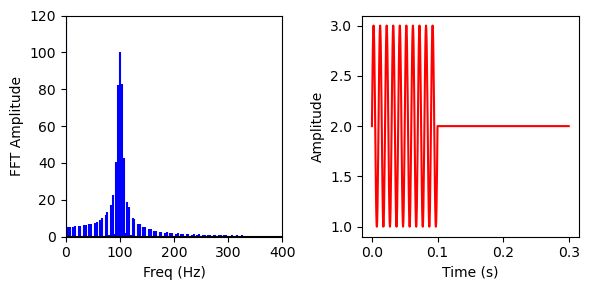

In [85]:
t = np.arange(0, 3*shake_duration, ts)
wd = 2*np.pi*shake_freq
deltaV_t_values = deltaV_t(wd, shake_duration, t)

deltaV_t_values_FT = fft(deltaV_t_values)
N = len(deltaV_t_values_FT)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (6, 3))
plt.subplot(121)

plt.stem(freq, np.abs(deltaV_t_values_FT), 'b', markerfmt = " ", basefmt="-k")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude')
plt.xlim(0, 400)
plt.ylim(0, 120)

plt.subplot(122)
plt.plot(t, deltaV_t_values, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

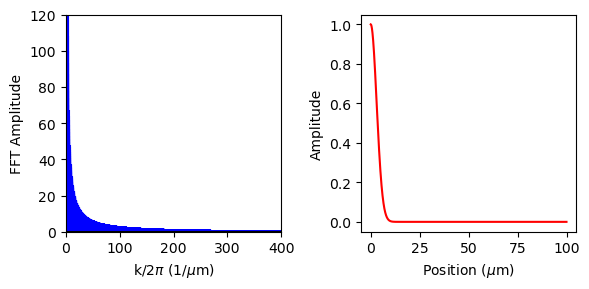

In [87]:
# box sampling rate:
sr_box = 100
bs = 1.0/sr_box
box = np.arange(0, L, bs)
sharpness = 3.0

deltaV_z_values = deltaV_z(box, sharpness)
deltaV_z_values_FT = fft(deltaV_z_values)
N_box = len(deltaV_z_values_FT)
n_box = np.arange(N_box)
L_box = N_box/sr
k = n_box/L_box 

plt.figure(figsize = (6, 3))
plt.subplot(121)

plt.stem(k, np.abs(deltaV_z_values_FT), 'b', markerfmt = " ", basefmt="-k")
plt.xlabel('k/$2\pi$ ($1/\mu$m)')
plt.ylabel('FFT Amplitude')
plt.xlim(0, 400)
plt.ylim(0, 120)

plt.subplot(122)
plt.plot(box, deltaV_z_values, 'r')
plt.xlabel('Position ($\mu$m)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

601
10000
(601, 10000)


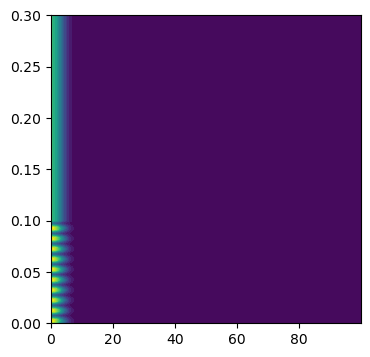

In [88]:
# make space of (z,t)
t_new = np.arange(0, 3*shake_duration, ts)
z_new = box

print(len(t_new))
print(len(z_new))

# make a z-t meshgrid:
z_MG, t_MG = np.meshgrid(z_new, t_new)

# make a matrix of V(z,t):
V_zt_MG = deltaV_z_t(z_MG, t_MG, sharpness=3.0, wd = wd, shake_duration = shake_duration)
print(V_zt_MG.shape)

# show space time diagram for V(z,t)
fig, ax = plt.subplots(figsize=(4,4))
ax.contourf(z_new, t_new, V_zt_MG, 20)
ax.set_aspect('auto')
plt.show()

(601, 10000)


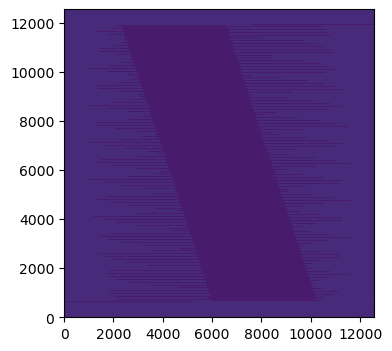

In [98]:
# now let's do a spatial FT on V_zt_MG:
w_new = 2*np.pi*freq
k_new = 2*np.pi*k

# generate V_kw_MG
V_kw_MG = fft2(V_zt_MG)
print(V_kw_MG.shape)

# show space time diagram for V(z,t)
fig, ax = plt.subplots(figsize=(4,4))
ax.contourf(k_new, w_new, np.real(V_kw_MG), 20)
ax.set_aspect('auto')
plt.show()


/Users/huanbui/anaconda3/envs/BEC1_Calculator/lib/python3.9/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/huanbui/anaconda3/envs/BEC1_Calculator/lib/python3.9/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/huanbui/anaconda3/envs/BEC1_Calculator/lib/python3.9/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


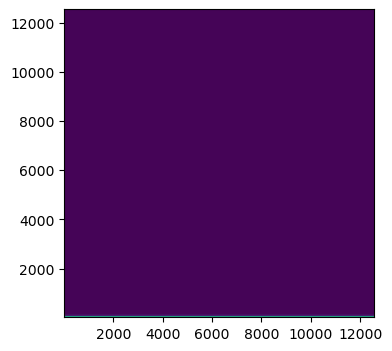

In [95]:
# now generate chi_n_FT_fake(k,w):
k_MG, w_MG = np.meshgrid(k_new, w_new)

chi_n_FT_fake_MG = chi_n_FT_fake(k_MG, w_MG, c=10000, Ds = 5)

# show space time diagram for V(z,t)
fig, ax = plt.subplots(figsize=(4,4))
ax.contourf(k_new, w_new, chi_n_FT_fake_MG, 50)
ax.set_aspect('auto')
plt.show()

TypeError: Length of x (10000) must match number of columns in z (9999)

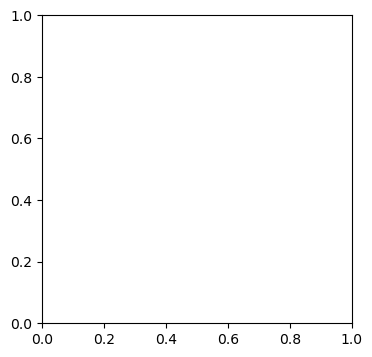

In [96]:
# calculate n_kw_MG:
n_kw_MG = chi_n_FT_fake_MG * V_kw_MG

# now inverse fft2 on n_kw_MG to get n_zt_MG:
n_zt_MG = ifft2(n_kw_MG)

# show space time diagram for V(z,t)
fig, ax = plt.subplots(figsize=(4,4))
ax.contourf(z_new, t_new, np.real(n_zt_MG), 20)
ax.set_aspect('auto')
plt.show()

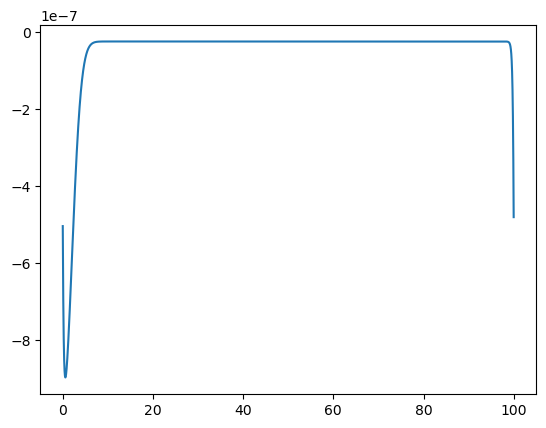

In [81]:
plt.plot(z_new, np.real(n_zt_MG)[333,:])